In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import kstest
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from scipy.stats import rankdata, norm

In [2]:
# Take a look at the California Housing dataset
california_df = pd.read_csv('./california_housing.csv')
california_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [3]:
california_df.drop('ocean_proximity', axis=1, inplace=True)

In [4]:
# Looking through the information about news dataset (looking for empty values)
california_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


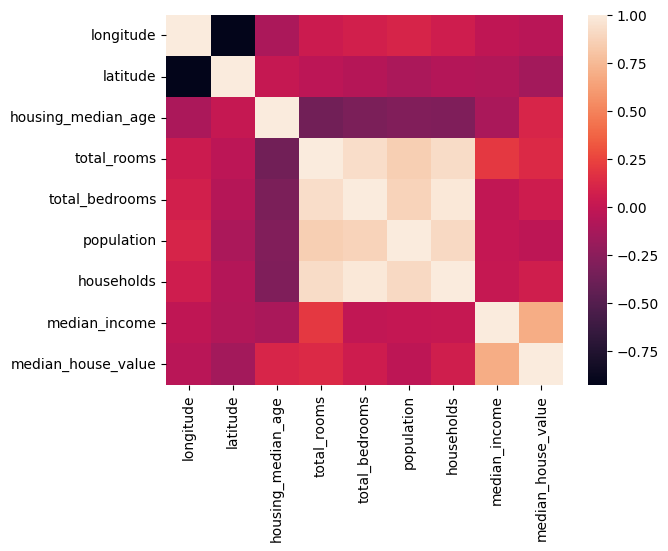

In [5]:
# Looking for correlated fatures
sns.heatmap(california_df.corr())
plt.show()

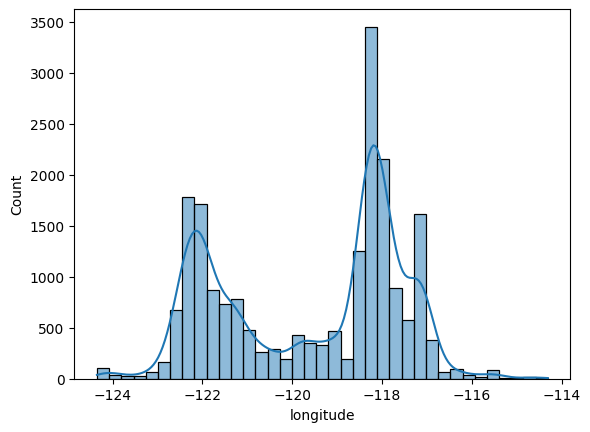

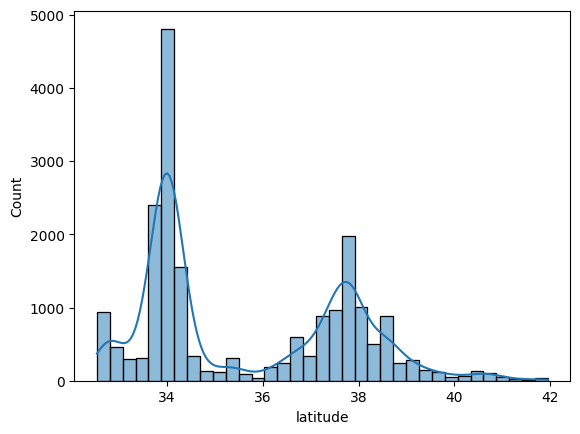

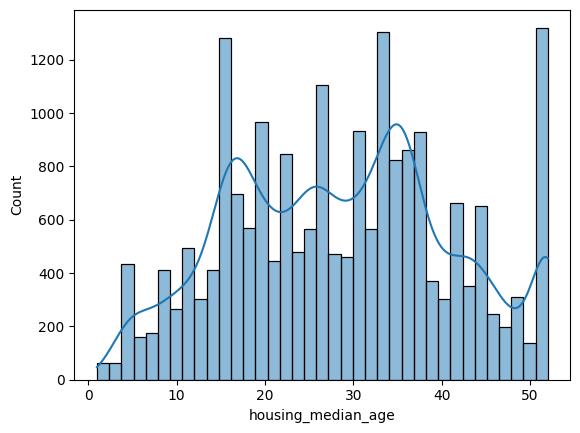

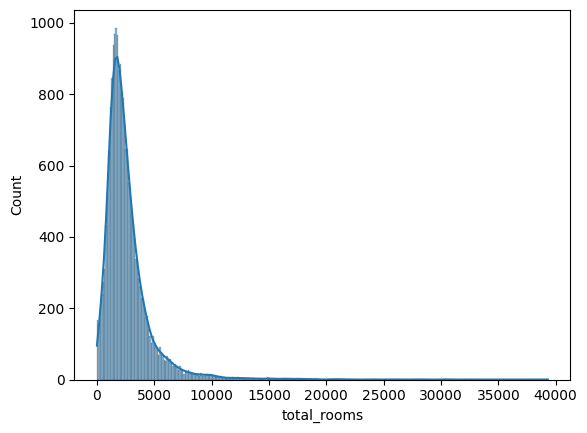

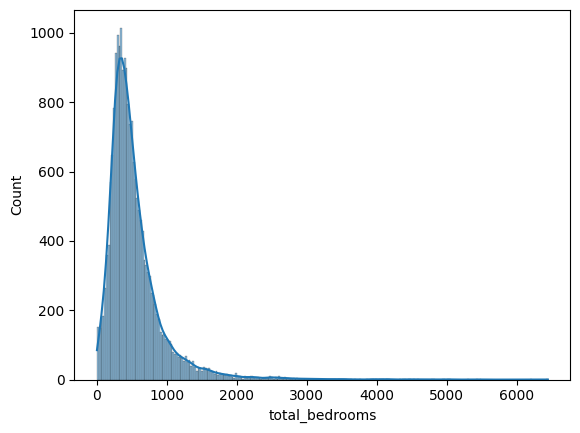

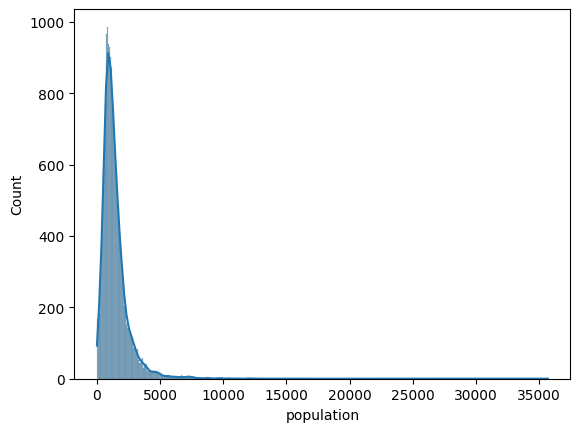

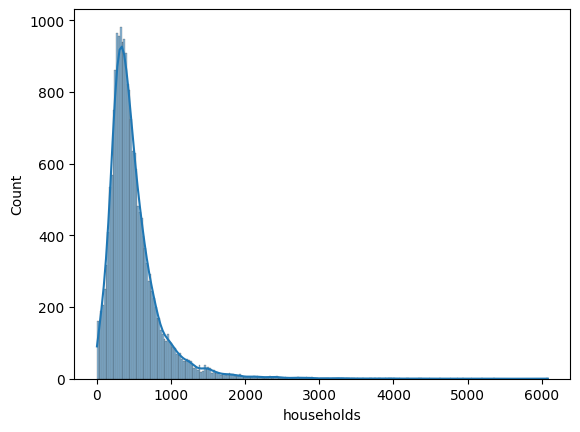

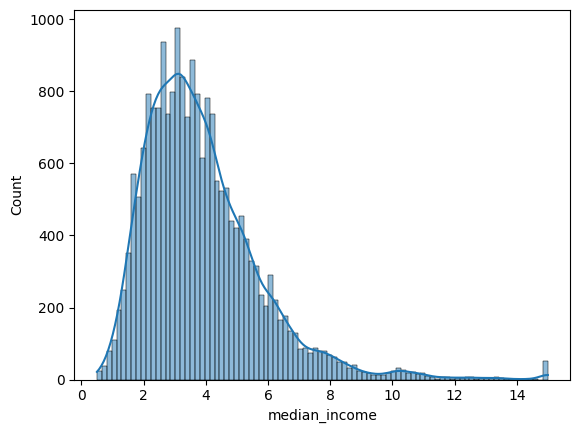

In [8]:
# Looking at the distributions of the features
features = list(california_df.columns)
features.remove('median_house_value')

features_num = list(range(0, len(features)))

for num in features_num:
    sns.histplot(california_df[features[num]], kde=True)
    plt.show()

In [9]:
# Create function for perform a rank-based transformation
def rank_transform(x):
    ranks = rankdata(x, method='average')
    return norm.ppf((ranks - 0.5) / len(ranks))

# Create a function for finding an optimal transformation method
def find_optimal_transformation(df, col):
    transformations = {
        'original': df[col],
        'log': np.log10(df[col]),
        'sqrt': np.sqrt(df[col]),
        'cbrt': np.cbrt(df[col]),
        'reciprocal': 1 / (df[col] + 1e-9),
        'rank': rank_transform(df[col]),
    }

    try:
        transformations['boxcox'], _ = stats.boxcox(df[col] + 1)
    except ValueError:
        pass

    pt = PowerTransformer(method='yeo-johnson')
    transformations['yeojohnson'] = pt.fit_transform(df[[col]]).flatten()

    # Using the Shapiro-Wilk criterion
    # results = {name: shapiro(trans)[1] for name, trans in transformations.items()}
    
    # Or use the Kolmogorov-Smirnov test
    results = {name: kstest(trans, 'norm')[1] for name, trans in transformations.items()}

    # Returning the transformation with the highest p-value
    optimal_transformation = max(results, key=results.get)
    return optimal_transformation, transformations[optimal_transformation]


In [10]:
# Creating a new dataframe for normalized values
transformed_df = pd.DataFrame()

# In a cycle apply the best transformation method and save it's values
for feature in features:
    optimal_transformation, transformed_values = find_optimal_transformation(california_df, feature)
    if optimal_transformation != 'original':
        transformed_df[f'{optimal_transformation}({feature})'] = transformed_values
    else:
        transformed_df[feature] = transformed_values
    print(f'The most optimal transformation for {feature} is {optimal_transformation}')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


The most optimal transformation for longitude is rank
The most optimal transformation for latitude is rank
The most optimal transformation for housing_median_age is rank
The most optimal transformation for total_rooms is rank
The most optimal transformation for total_bedrooms is original
The most optimal transformation for population is rank
The most optimal transformation for households is rank
The most optimal transformation for median_income is rank


In [11]:
transformed_df

,rank(longitude),rank(latitude),rank(housing_median_age),rank(total_rooms),total_bedrooms,rank(population),rank(households),rank(median_income)
0,-1.152706,0.901549,0.912636,-1.352665,129.0,-1.697343,-1.639242,1.921255
1,-1.138312,0.885707,-0.479764,1.816886,1106.0,1.192805,1.619773,1.917424
2,-1.170108,0.877736,1.868615,-0.652243,190.0,-1.315410,-1.324114,1.629316
3,-1.190582,0.877736,1.868615,-0.872837,235.0,-1.174817,-1.066942,1.083394
4,-1.190582,0.877736,1.868615,-0.468620,280.0,-1.163631,-0.810024,0.193200
...,...,...,...,...,...,...,...,...
20635,-0.416380,1.882362,-0.241951,-0.432194,374.0,-0.554815,-0.387741,-1.688942
20636,-0.436197,1.886305,-0.692746,-1.567881,150.0,-1.626574,-1.701202,-0.681213
20637,-0.439338,1.866878,-0.794276,0.100971,485.0,-0.252908,0.103107,-1.499402
20638,-0.499066,1.866878,-0.692746,-0.232021,409.0,-0.774207,-0.287359,-1.319025


In [13]:
# Take a target column from intial dataset
value_column = california_df['median_house_value']

# Insert target column into transformed dataset
transformed_df.insert(8, 'meadian_house_value', value_column, True)
transformed_df

,rank(longitude),rank(latitude),rank(housing_median_age),rank(total_rooms),total_bedrooms,rank(population),rank(households),rank(median_income),meadian_house_value
0,-1.152706,0.901549,0.912636,-1.352665,129.0,-1.697343,-1.639242,1.921255,452600.0
1,-1.138312,0.885707,-0.479764,1.816886,1106.0,1.192805,1.619773,1.917424,358500.0
2,-1.170108,0.877736,1.868615,-0.652243,190.0,-1.315410,-1.324114,1.629316,352100.0
3,-1.190582,0.877736,1.868615,-0.872837,235.0,-1.174817,-1.066942,1.083394,341300.0
4,-1.190582,0.877736,1.868615,-0.468620,280.0,-1.163631,-0.810024,0.193200,342200.0
...,...,...,...,...,...,...,...,...,...
20635,-0.416380,1.882362,-0.241951,-0.432194,374.0,-0.554815,-0.387741,-1.688942,78100.0
20636,-0.436197,1.886305,-0.692746,-1.567881,150.0,-1.626574,-1.701202,-0.681213,77100.0
20637,-0.439338,1.866878,-0.794276,0.100971,485.0,-0.252908,0.103107,-1.499402,92300.0
20638,-0.499066,1.866878,-0.692746,-0.232021,409.0,-0.774207,-0.287359,-1.319025,84700.0


In [14]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   rank(longitude)           20640 non-null  float64
 1   rank(latitude)            20640 non-null  float64
 2   rank(housing_median_age)  20640 non-null  float64
 3   rank(total_rooms)         20640 non-null  float64
 4   total_bedrooms            20433 non-null  float64
 5   rank(population)          20640 non-null  float64
 6   rank(households)          20640 non-null  float64
 7   rank(median_income)       20640 non-null  float64
 8   meadian_house_value       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [15]:
df_cleaned = california_df.dropna(subset=['total_bedrooms'])
df_cleaned

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0
...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0


In [17]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
dtypes: float64(9)
memory usage: 1.6 MB


In [18]:
# Save transformed dataset as .csv file
df_cleaned.to_csv('prep_california_housing.csv', index=False)

### Now the dataset has no empty values and categorical features; all features are approximately independent and all featrues' distributions are approximately normal